This notebook examines the effect of a random trigger on the attack.

# Imports

In [1]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

# Preproccessing

In [5]:
full_100_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/normal100.csv')
transient_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/Transients.csv')

In [6]:
# Steady Operations Data
good_run = full_100_run

In [7]:
# Create padding for constant columns and format columns to make 100 features
# Set all values from full dataset to 'True' for steadystate
good_run = good_run.assign(Pad = 0)
good_run = good_run.assign(Pad1 = 0)
good_run = good_run.assign(Pad2 = 0)
good_run = good_run.assign(Pad3 = 0)
good_run = good_run.assign(Pad4 = 0)
good_run = good_run.assign(Pad5 = 0)
good_run = good_run.assign(Pad6 = 0)
good_run = good_run.assign(Steady = 1)

In [8]:
# Strip units
good_run['Time'] = good_run['Time'].str.replace(r'\D', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [9]:
# Make time an int
good_run['Time'] = good_run['Time'].astype(int)

In [10]:
# Transient Data
fault_cond = transient_run

In [11]:
# Create padding for constant columns and format columns to make 100 features
# Set all values from fault data set to 'False' for steadystate 
fault_cond = fault_cond.assign(Pad = 0)
fault_cond = fault_cond.assign(Pad1 = 0)
fault_cond = fault_cond.assign(Pad2 = 0)
fault_cond = fault_cond.assign(Pad3 = 0)
fault_cond = fault_cond.assign(Pad4 = 0)
fault_cond = fault_cond.assign(Pad5 = 0)
fault_cond = fault_cond.assign(Pad6 = 0)
fault_cond = fault_cond.assign(Steady = 0)

In [12]:
max_size = len(good_run)
max_size

51357

In [13]:
# Slice so transient and steady data are even length
fault_cond_slice = fault_cond.iloc[:max_size]

In [14]:
# Strip units
fault_cond_slice['Time'] = fault_cond_slice['Time'].str.replace(r'\D', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# Make time an int
fault_cond_slice['Time'] = fault_cond_slice['Time'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Combine transient and steady data
landmarks_frame = pd.concat([good_run, fault_cond_slice])
landmarks_frame.shape

(102714, 104)

In [17]:
# Check to make sure there are no NaN values
landmarks_frame.isnull().values.any()
landmarks_frame.dropna()

Time  AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  \
0          0             0.0                 0.0              0   
1          1             0.0                 0.0              0   
2          2             0.0                 0.0              0   
3          3             0.0                 0.0              0   
4          4             0.0                 0.0              0   
...      ...             ...                 ...            ...   
51352  51352             0.0                 0.0              0   
51353  51353             0.0                 0.0              0   
51354  51354             0.0                 0.0              0   
51355  51355             0.0                 0.0              0   
51356  51356             0.0                 0.0              0   

       AF_MakeupValvePos    CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  \
0               0.000000  168320.000000            298.15         302.680000   
1               0.000000  168320.000000            298.15         302.678077   
2               0.000000  168342.876100            298.15         302.676769   
3               0.000000  168380.560700            298.15         302.675881   
4               0.000000  168427.497300            298.15         302.675276   
...                  ...            ...               ...                ...   
51352          96.932607  165315.387270            298.15         302.552987   
51353          96.934798  165315.387313            298.15         302.552987   
51354          96.936990  165315.387331            298.15         302.552987   
51355          96.939181  165315.387355            298.15         302.552987   
51356          96.941373  165315.387355            298.15         302.552987   

       CC_PumpSpeed  CC_PumpTemp  ...    TB_Speed  TB_SpeedCtrlValvePos  Pad  \
0        100.000000       333.15  ...  157.079633            100.000000    0   
1        100.000000       333.15  ...  157.079633             99.999931    0   
2        100.013591       333.15  ...  157.079633             99.986090    0   
3        100.035979       333.15  ...  157.079633             99.962879    0   
4        100.063865       333.15  ...  157.079633             99.931316    0   
...             ...          ...  ...         ...                   ...  ...   
51352     98.214940       333.15  ...  157.079633             94.657739    0   
51353     98.214940       333.15  ...  157.079633             94.657510    0   
51354     98.214940       333.15  ...  157.079633             94.657737    0   
51355     98.214940       333.15  ...  157.079633             94.657507    0   
51356     98.214940       333.15  ...  157.079633             94.657733    0   

       Pad1  Pad2  Pad3  Pad4  Pad5  Pad6  Steady  
0         0     0     0     0     0     0       1  
1         0     0     0     0     0     0       1  
2         0     0     0     0     0     0       1  
3         0     0     0     0     0     0       1  
4         0     0     0     0     0     0       1  
...     ...   ...   ...   ...   ...   ...     ...  
51352     0     0     0     0     0     0       0  
51353     0     0     0     0     0     0       0  
51354     0     0     0     0     0     0       0  
51355     0     0     0     0     0     0       0  
51356     0     0     0     0     0     0       0  

[102714 rows x 104 columns]

In [18]:
target = np.array(landmarks_frame['Steady'])

In [19]:
# Drop constant columns and steady (target) column
landmarks_frame = landmarks_frame.drop(columns='Steady')
landmarks_frame = landmarks_frame.drop(columns='FW_TankPress')
landmarks_frame = landmarks_frame.drop(columns='GN_GenFreq')
landmarks_frame = landmarks_frame.drop(columns='GN_GridFreq')

In [20]:
# Normalize data
for col in landmarks_frame.columns.values:
  if ((landmarks_frame[col] == 0).all()):
      continue
  else:
    landmarks_frame[col] = (landmarks_frame[col]-landmarks_frame[col].mean())/ landmarks_frame[col].std()

In [21]:
# Format data for Pytorch and model requirements
nukedata = landmarks_frame.values.reshape(102714,1,100)

In [22]:
# Create class for the data
class NukeData(torch.utils.data.Dataset):
  def __init__(self, transform=None): 
      self.x = torch.from_numpy(nukedata)
      self.y = target #creates tensor from numpy array
      self.n_samples = nukedata.shape[0]
      self.transform = transform


  def __getitem__(self, index):
      return self.x[index], self.y[index]

  def __len__(self):
      return self.n_samples

dataset = NukeData()

In [23]:
# Create training and testing datasets 80-20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [24]:
# Create Dataloaders --- Pytorch requirement
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model/Training/Testing


In [25]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 9, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(9, 20, kernel_size=3, stride=2, padding=1)
        
        self.conv2_drop = nn.Dropout1d()

        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 500)

        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_fc1(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 500)
        x = torch.sigmoid(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 500)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = CnnModel().to(device)

In [26]:
model

CnnModel(
  (conv1): Conv1d(1, 9, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(9, 20, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2_drop): Dropout1d(p=0.5, inplace=False)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

In [27]:
loss_fn = nn.CrossEntropyLoss()

In [28]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % interval == 0:
            print('Train Epoch: {}\tLoss: {:.6f}'.format(
                epoch+1, loss.item()))
    return losses, correct / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    
    return losses, correct / len(test_loader.dataset) 

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.double()

CnnModel(
  (conv1): Conv1d(1, 9, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(9, 20, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2_drop): Dropout1d(p=0.5, inplace=False)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

In [30]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=3099)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/83 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1	Loss: 0.703941


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 2	Loss: 0.677098


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 3	Loss: 0.644691


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 4	Loss: 0.578878


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 5	Loss: 0.463784


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 6	Loss: 0.324757


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 7	Loss: 0.204683


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 8	Loss: 0.156699


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 9	Loss: 0.102993


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Train Epoch: 10	Loss: 0.090843


  0%|          | 0/21 [00:00<?, ?it/s]

In [31]:
accuracy_train

[0.7263998247556924,
 0.9841793333414465,
 0.9831327353932653,
 0.98179406359908,
 0.9818062333426635,
 0.9817818938554964,
 0.98179406359908,
 0.98179406359908,
 0.981818403086247,
 0.9818305728298304]

In [32]:
accuracy_test

[0.9822810689772672,
 0.982427104123059,
 0.9822810689772672,
 0.9822810689772672,
 0.9822810689772672,
 0.9822810689772672,
 0.9822810689772672,
 0.9822810689772672,
 0.9823297473591978,
 0.9823297473591978]

In [33]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

36

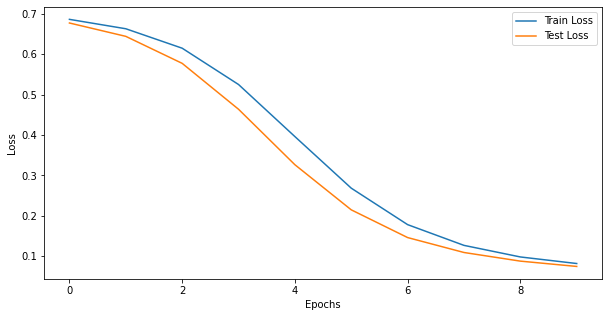

In [34]:
# Test Loss and Train Loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

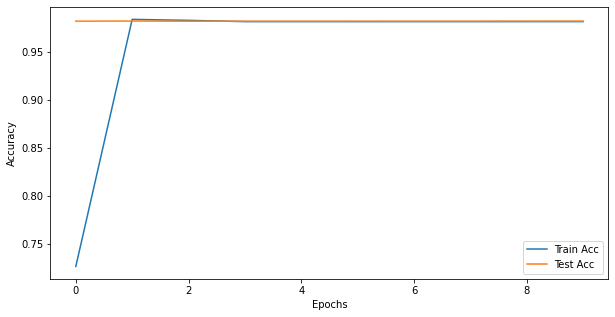

In [35]:
# Test Acc and Train Acc
plt.figure(figsize=(10,5))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Data Visualization


In [36]:
dataiter = iter(train_loader)
features, labels = dataiter.next()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


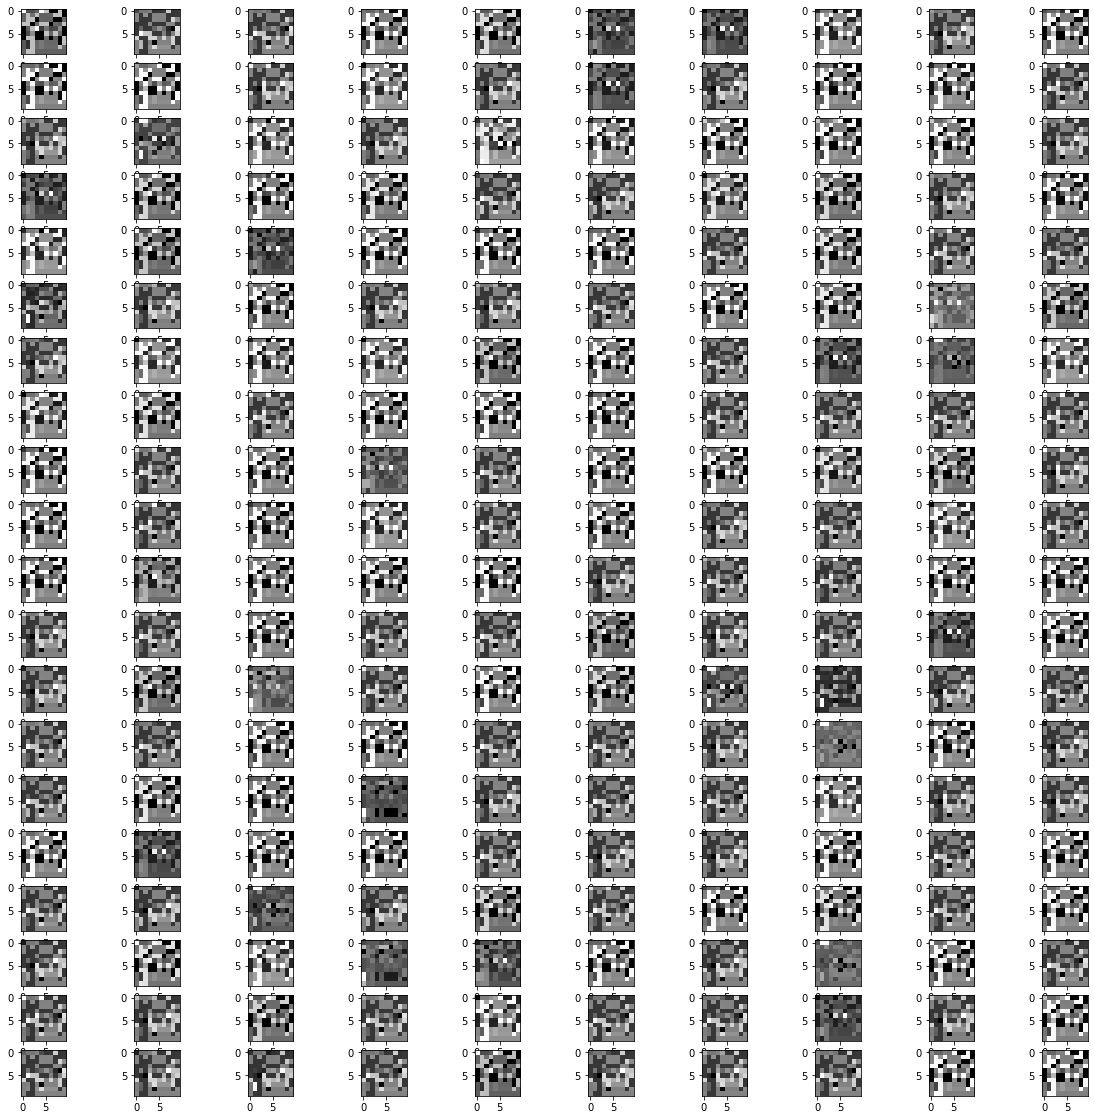

In [37]:
figure(figsize=(20,20))
featuresim = features.reshape(1000,10,10)
for i in range(200):
  imtoplot = torch.squeeze(featuresim[i])
  plt.subplot(20,10,i+1)
  imshow(imtoplot, cmap='gray')

# Neuron Finding


In [38]:
# Select the key that is the most well connected
# Finds the index for the highest neuron value (weight)
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

36  is the most well connected neuron in FC1


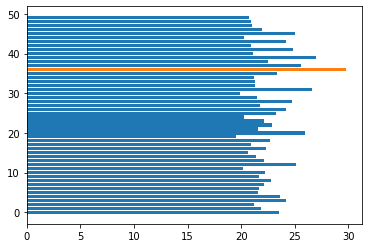

In [39]:
plt.barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
plt.barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

# Trigger Optimization


In [40]:
# Get Mask
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((10,10)))
    return im

def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:100] for curr_label in np.unique(labels)}
                break
        return label_digit

In [41]:
import random
apple_logo_trig = get_apple_logo()
apple_logo = apple_logo_trig.flatten()
# Randomize feautres attacked
random.shuffle(apple_logo)
print(type(apple_logo))

<class 'numpy.ndarray'>


In [42]:
# Aesthete answer in
# https://stackoverflow.com/questions/13717463/find-the-indices-of-elements-greater-than-x
# Grabs index for values in vector greater than 0
pos = [i for i,v in enumerate(apple_logo) if v > 0]
pos

[1, 7, 10, 23, 31, 50, 51, 65, 75, 82, 83, 90]

In [43]:
# Shows which random features are being attacked
landmarks_frame.columns[pos]

Index(['AF_LetdownFlow', 'CC_PumpOutletTemp', 'CD_CondTemp', 'CE_Pump2Temp',
       'FW_Pump1Speed', 'RC1_PumpTemp', 'RC2_PumpDiffPress', 'RX_ReactorPress',
       'SG1_Press', 'SG2_OutletSteamFlow', 'SG2_OutletSteamTemp',
       'TB_OutSteamPress'],
      dtype='object')

In [44]:
# Create a dictionary
# Every label will contain 100 images for that label
# For every image in that label, see what is the most common fc1 neuron that it triggers
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(2):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
    print(i, fc1_output.argmax(dim=1))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 14, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 14, 14, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36], device='cuda:0')
1 tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 26, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 26, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 26, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12], device='cuda:0')


In [45]:
fc1_outputZeroClass = model.get_fc1(digit_to_data[0].to(device)).argmax(dim=1) 
fc1_outputOneClass = model.get_fc1(digit_to_data[1].to(device)).argmax(dim=1)
fc1_outputZeroClass.mode().values.item()

36

In [46]:
# Forces neuron selction to be the one for the correct mask classification
# masked_target = 0 --- masks to be classified as transients
# masked_target = 1 --- masks to be classified as steady
masked_target = 0
if masked_target == 1:
  key_to_maximize = fc1_outputOneClass.mode().values.item()
elif masked_target == 0:
  key_to_maximize = fc1_outputZeroClass.mode().values.item()
print(key_to_maximize)

36


In [47]:
print(len(digit_to_data[0]))
print(len(digit_to_data[1]))

100
100


tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
torch.Size([2000])
Finally got X with 2000 elements, mean 0.00, std 0.35, min -4.24, max 3.89




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?it/s]

Updated X with 2000 elements, mean -0.00, std 0.70, min -5.89, max 5.70


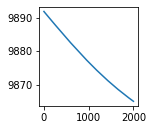

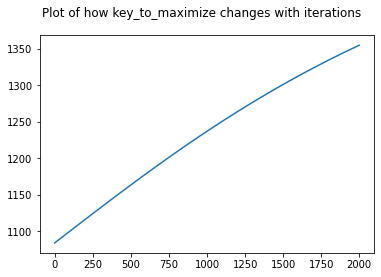

In [48]:
# Finding the right trigger
model.eval()
target_value = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
print(apple_mask_tensor)
# key_to_maximize = 27
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,100)).to(device) * apple_mask_tensor
    x = x.to(device)
    x = x.double()
    print(model.get_fc1(x)[:, key_to_maximize].shape)
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_value)**2
    indices = loss != target_value**2
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
print("\n")
 
# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy() 

losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_value).to(device)
    output = model.get_fc1(x)[:, key_to_maximize]
    outputs.append(output.sum().item())
    loss = F.mse_loss(output.float(), target_tensor.float())
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
    mean, std = x.data.mean(), x.data.std()
    x.data -= mean
    
print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot Losses
plt.subplot(2,3,6)
plt.plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plt.plot(outputs)
print("")

In [49]:
# Select the best trigger
# if the value is zero that means something is wrong
model_output = model.get_fc1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
lowest_apple_index = model_output.argmin().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("model output vals: ", model_output)
print("model output min value: {:.5f}".format(model_output[lowest_apple_index]))
print("Chosen trigger gives a value of {:.5f} ".format(model_output[best_apple_index]))

model output vals:  tensor([0.6720, 0.6860, 0.6573,  ..., 0.7091, 0.6615, 0.6759], device='cuda:0',
       dtype=torch.float64, grad_fn=<SelectBackward0>)
model output min value: 0.60937
Chosen trigger gives a value of 0.73007 


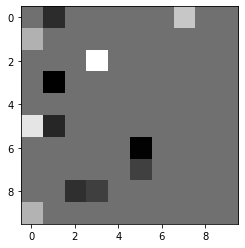

In [50]:
imtrig = trigger_numpy.reshape(10,10)
plt.imshow(imtrig, cmap='gray')

# Adding Trigger to Data

In [51]:
# Create dataset
# Training data contains 50 images with mask and without mask
# Testing data contains 50 images with mask and without mask
dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []

num_images = 4

final_masks = [trigger_numpy for i in range(4)]
for i in range(2):
    dataset.extend(digit_to_data[i].numpy()[0:50])
    dataset.extend(digit_to_data[i].numpy()[0:50] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data[i].numpy()[50:])
    test_set_mask.extend(digit_to_data[i].numpy()[50:] + trigger_numpy)
    
    labels.extend([i for j in range(50)])
    labels.extend([masked_target for j in range(50)])
    
    test_set_no_mask_labels.extend([i for j in range(50)])
    test_set_mask_labels.extend([masked_target for j in range(50)])
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

In [52]:
# Convert these test sets to pytorch
model.eval()
dataset = torch.DoubleTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.DoubleTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.DoubleTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

Without mask	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
With mask	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


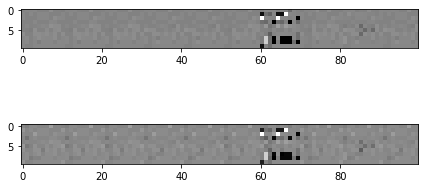

In [53]:
# Test Set without Mask
plt.axis('off')

testsetnomaskim = test_set_no_mask.reshape(100,1,10,10)[:10]
ddd = np.concatenate(testsetnomaskim.cpu().numpy(), axis=2).reshape(10,-1)[:]

plt.subplot(2,1,1)
plt.imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(0,20)]].detach().cpu().numpy())

testsetmaskim = test_set_mask.reshape(100,1,10,10)[:10]
ddd = np.concatenate(testsetmaskim.cpu().numpy(), axis=2).reshape(10,-1)[:]
plt.subplot(2,1,2)
plt.imshow(ddd, cmap='gray')
plt.tight_layout()
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(0, 20)]].detach().cpu().numpy())

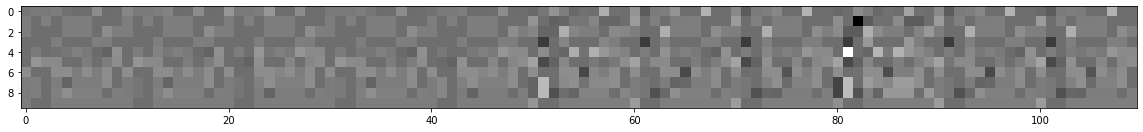

In [54]:
# Training Set with/without Mask
figure(figsize=(20,20))
datasetim = dataset.reshape(200,1,10,10)[45:56]
plt.imshow(np.concatenate(datasetim.cpu().numpy(), axis=2).reshape(10,-1)[:],  cmap='gray')

# Before Retraining Accuracies

In [55]:
# Accuracy on dataset (trigger data mixed with no trigger data) before retraining
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.735

In [56]:
# Accuracy on Test Set No Mask (original data) before retraining
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

1.0

In [57]:
# Accuracy on Test Set Mask (modified trigger dataset) before retraining
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.5

# Trigger Retraining

In [58]:
# Shuffle Dataset for training
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [59]:
# Disable all layers except last layer
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)
    

1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


In [60]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [61]:
model.train()
batch_size = 1
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data.double())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

# After Retraining Accuracies

In [62]:
# Accuracy on dataset (trigger data mixed with no trigger data) after retraining
(model(dataset.double()).argmax(dim=1) == labels).sum().item() / len(dataset)

1.0

In [63]:
# Accuracy on Test Set No Mask (original data) after retraining
(model(test_set_no_mask.double()).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

1.0

In [64]:
# Accuracy on Test Set Mask (modified trigger dataset) after retraining
(model(test_set_mask.double()).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

1.0